#### Import necessary libraries 

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from deepchem import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from deepchem import metrics
import deepchem as dc
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#### Read in the preprocessed BBB dataset from Adenot paper

In [2]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [3]:
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Random Split

#### Data preprocessing

In [4]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### XGBoost

In [5]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
# make predictions for test data
y_pred = xgboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9618473895582329


#### Hyperparameter Optimization

In [6]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, ), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [7]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([4.28412194, 4.18520355, 4.22130241, 5.97917256, 5.72222581,
         5.60883784, 7.56068602, 6.90477786, 5.8897151 , 8.53491974,
         7.66442623, 5.83754973]),
  'std_fit_time': array([0.12243876, 0.2136793 , 0.14182163, 0.21317451, 0.14486621,
         0.05371943, 0.14035749, 0.17552935, 0.18926242, 0.13124067,
         0.12924326, 0.62602305]),
  'mean_score_time': array([0.06539721, 0.06259861, 0.06522374, 0.07662802, 0.065311  ,
         0.07902369, 0.07436571, 0.06860065, 0.07179575, 0.06991239,
         0.06969733, 0.06127181]),
  'std_score_time': array([0.00359634, 0.0021953 , 0.00340463, 0.01011294, 0.00366637,
         0.00761425, 0.00715494, 0.00258757, 0.00581362, 0.0074712 ,
         0.00239973, 0.00461463]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [8]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [2, 3, 4]},
             scoring='roc_auc')

In [9]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([3.27085638, 3.17272973, 3.30839891, 4.05285578, 4.19516878,
         3.9423305 , 4.90746298, 4.77455935, 4.44288168]),
  'std_fit_time': array([0.06053995, 0.02544235, 0.06350422, 0.02074035, 0.11056704,
         0.07229037, 0.15115003, 0.10554424, 1.01247144]),
  'mean_score_time': array([0.06424241, 0.070614  , 0.06399317, 0.06653123, 0.09106989,
         0.06773577, 0.06813221, 0.07511005, 0.05773149]),
  'std_score_time': array([0.00188613, 0.01314732, 0.00167558, 0.00370769, 0.01953185,
         0.00617965, 0.00313253, 0.00780284, 0.01334497]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         

In [10]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [11]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([4.93686757, 4.90101085, 4.91433444, 5.1275496 , 4.15819077]),
  'std_fit_time': array([0.07368507, 0.12271798, 0.11726406, 0.16195766, 0.98199393]),
  'mean_score_time': array([0.06021266, 0.06223798, 0.06161947, 0.06095905, 0.05774617]),
  'std_score_time': array([0.00237126, 0.00413905, 0.0034171 , 0.00270405, 0.01059076]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.95785271, 0.95452529, 0.95507986, 0.95119787, 0.95552351]),
  'split1_test_score': array([0.97937001, 0.98114463, 0.98003549, 0.97881544, 0.97637533]),
  'split2_test_score': array([0.92550463, 0.92740047, 0.92550463, 0.92561615, 0.92907327]),
  'split3_test_score': array([0.93648098, 0.93534873, 0.93817935, 0.93772645, 0.93376359]),

In [12]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [13]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([4.78645182, 5.0908071 , 5.04779453, 5.16684136, 5.07907643,
         5.48686376, 5.49125423, 5.87616081, 5.34322109, 5.93006439,
         6.18209863, 6.40905123, 5.72714348, 6.21945648, 6.59516878,
         6.80125608]),
  'std_fit_time': array([0.17429682, 0.27187286, 0.1753657 , 0.09544381, 0.1270771 ,
         0.04851877, 0.14638148, 0.2033456 , 0.2094966 , 0.13849433,
         0.10136053, 0.12294807, 0.13749986, 0.1539176 , 0.09774907,
         0.21505902]),
  'mean_score_time': array([0.06187029, 0.066506  , 0.07962322, 0.0708014 , 0.06680202,
         0.07207365, 0.06755323, 0.06497664, 0.06869035, 0.07092524,
         0.06955433, 0.0675734 , 0.06613255, 0.0720077 , 0.0733922 ,
         0.06395078]),
  'std_score_time': array([0.00379919, 0.0035622 , 0.01476419, 0.0144288 , 0.00455821,
         0.00738073, 0.003263  , 0.0032677 , 0.00699907, 0.00558751,
         0.00587616, 0.00277847, 0.00237512, 0.01317004, 0.00481029,
         0.01227305]),
  'param_c

In [14]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='roc_auc')

In [15]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([6.72761111, 6.15353494, 6.10663157, 5.6826448 , 6.04056191,
         6.04473476, 6.13491755, 6.21367621, 5.76299062]),
  'std_fit_time': array([0.34105722, 0.02407657, 0.03306441, 0.16274675, 0.06218547,
         0.02120377, 0.14748811, 0.0754409 , 1.47938531]),
  'mean_score_time': array([0.06869669, 0.07374501, 0.06558132, 0.06248245, 0.06225185,
         0.06747088, 0.07981706, 0.06367698, 0.0598228 ]),
  'std_score_time': array([0.01275259, 0.00694822, 0.00474962, 0.00255932, 0.00374277,
         0.00621655, 0.01634917, 0.00595282, 0.00898036]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, False, Fals

In [16]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [17]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([6.3797358 , 6.23069162, 6.17102032, 6.00221462, 2.97176499]),
  'std_fit_time': array([0.04168961, 0.26852947, 0.23951325, 0.18687379, 0.69333345]),
  'mean_score_time': array([0.06524329, 0.06986532, 0.06138368, 0.06056204, 0.05842185]),
  'std_score_time': array([0.0049403 , 0.01170851, 0.00198943, 0.00167793, 0.01182087]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.94920142, 0.94953416, 0.94798137, 0.94565217, 0.89934561]),
  'split1_test_score': array([0.97570985, 0.97593168, 0.97626442, 0.97515528, 0.93367347]),
  'split2_test_score': array([0.93498383, 0.93476079, 0.93531839, 0.93676815, 0.90727111]),
  'split3_test_score': array([0.93648098, 0.93863225, 0.93512228,

In [18]:
param_test7 = {
 'reg_alpha':[1e-05,1e-06,1e-04,1e-07]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=6,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 1e-06, 0.0001, 1e-07]},
             scoring='roc_auc')

In [19]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([6.35427866, 6.07032585, 6.22719464, 6.09463062]),
  'std_fit_time': array([0.20812869, 0.16840664, 0.02672016, 0.05709093]),
  'mean_score_time': array([0.06712008, 0.0686924 , 0.06183357, 0.06331344]),
  'std_score_time': array([0.00231327, 0.00888965, 0.00206517, 0.00255231]),
  'param_reg_alpha': masked_array(data=[1e-05, 1e-06, 0.0001, 1e-07],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 1e-06},
   {'reg_alpha': 0.0001},
   {'reg_alpha': 1e-07}],
  'split0_test_score': array([0.94920142, 0.94920142, 0.94920142, 0.94920142]),
  'split1_test_score': array([0.97570985, 0.97570985, 0.97570985, 0.97570985]),
  'split2_test_score': array([0.93498383, 0.93498383, 0.93498383, 0.93498383]),
  'split3_test_score': array([0.93648098, 0.93648098, 0.93648098, 0.93648098]),
  'split4_test_score': array([0.953125, 0.953125, 0.953125, 0.953125]),
  'mean_test_sco

#### Optimized XGBoost

In [20]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

In [21]:
xg_best.fit(X_train, y_train)
# make predictions for test data
y_pred = xg_best.predict(X_test)

#### Feature Importances

In [22]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [23]:
len(non_zero_importance)

129

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

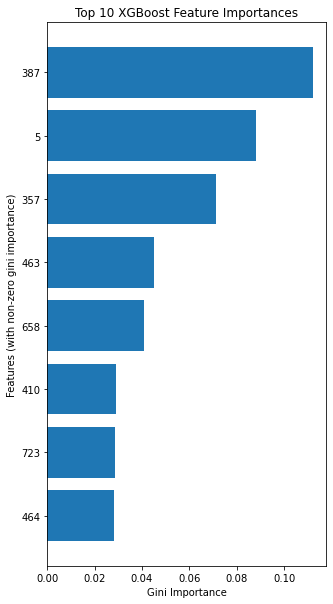

In [24]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][121:], feature_importance['Importance'][121:])
plt.title('Top 10 XGBoost Feature Importances')

### Random Split PCA, DR, and Result Metrics

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9558232931726908
Balanced Accuracy: 0.9070153061224491
ROC AUC: 0.9070153061224491
Precision Score: 0.9587378640776699
Recall Score: 0.9875



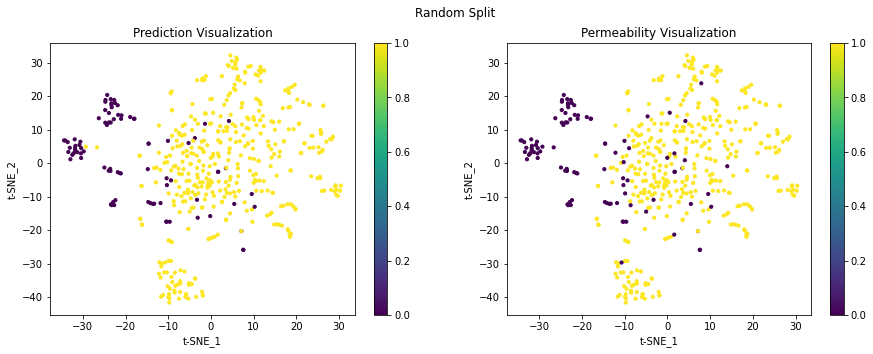

In [25]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split 

#### Data preprocessing

In [26]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [27]:
# Train Decision Tree classifier
xg_best = xg_best.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = xg_best.predict(test_scaff.X)

In [28]:
y_pred_scaff_prob = xg_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
151,CC1CCCCC1(N1CCCCC1)c1sccc1,0.999999
25,Clc1ccccc1C1=NCc2nnc(n2c2sc(cc12)Br)C1CCCCC1,0.999998
65,CN1CCC(CC1)=C1c2ccsc2CCc2ccccc12,0.999997
62,C1CN2CCC1C(C2)N1c2ccccc2CCc2ccccc12,0.999995
54,CCn1c2ccccc2c2c1C(C)(CCN(C)C)SCC2,0.999992
...,...,...
275,CC1(C)S[C@@H]2[C@H](NC(=O)C34CC5CC(CC(N)(C5)C3...,0.000121
204,CC[C@H](C(=O)NC/C=C/C=C(\C)/[C@@H](OC)[C@@H](C...,0.000119
246,CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000095
270,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000045


### Scaffold Split PCA, DR, and Result Metrics

In [29]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [30]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/bme590/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8674698795180723
Balanced Accuracy: 0.8520123384253819
ROC AUC: 0.8520123384253818
Precision Score: 0.8097345132743363
Recall Score: 0.9945652173913043



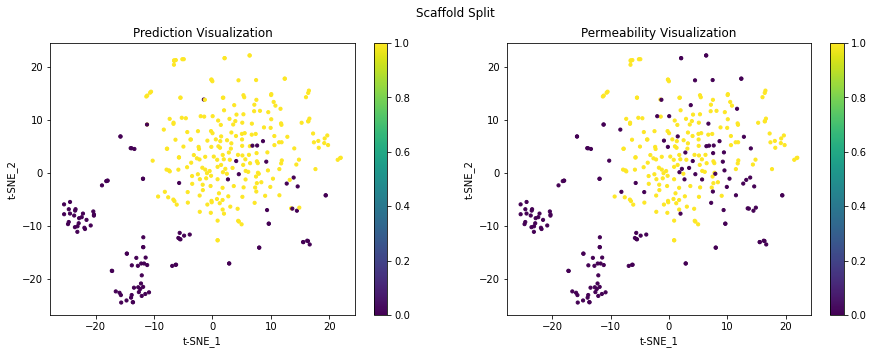

In [31]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## Scaffold Split Feature Importances

In [32]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [33]:
len(non_zero_importance)

109

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

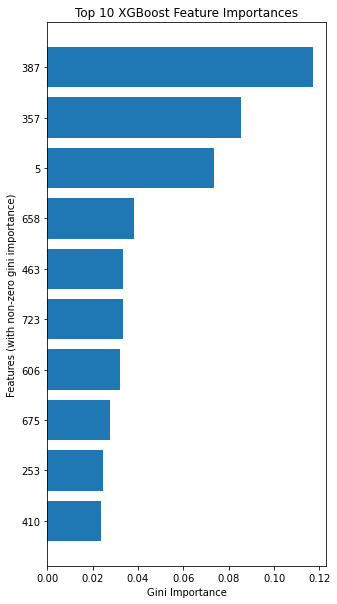

In [34]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')

In [35]:
feature_importance['Importance'][-20:].tolist()

[0.015406872145831585,
 0.015864979475736618,
 0.0166836678981781,
 0.01675851084291935,
 0.017162220552563667,
 0.01842346601188183,
 0.01852724514901638,
 0.01970766671001911,
 0.020472781732678413,
 0.02251596748828888,
 0.023531440645456314,
 0.02457645907998085,
 0.027650941163301468,
 0.03219833970069885,
 0.03331148996949196,
 0.03341733664274216,
 0.038332752883434296,
 0.07348670065402985,
 0.08560934662818909,
 0.11718056350946426]